In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
from astropy.table import Table
from mica.vv import get_rms_data
import chandra_aca
from chandra_aca.dark_model import get_warm_fracs
from Ska.Matplotlib import plot_cxctime
from Chandra.Time import DateTime
from sherpa import ui

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find xpaget on your PATH'


In [2]:
rms_data = Table(get_rms_data())

In [3]:
rms_data = rms_data[(rms_data['isdefault'] == 1)
                    & (rms_data['type'] == b'GUIDE')
                    & (rms_data['used'] == 1)
                    & (rms_data['tstart'] > DateTime('2008:001').secs)
                    ]

In [4]:
obs_by_obsid = rms_data.group_by('obsid')
obs_min = obs_by_obsid[['obsid', 'dr_rms','dy_rms', 'dz_rms','tstart', 'mean_aacccdpt']].groups.aggregate(np.min)

In [5]:
limit = 100

In [6]:
# This needs the new dark model for the right warm pixel fractions
assert chandra_aca.__version__ in ['3.15', '3.16.1', '3.17']

In [7]:
chandra_aca.__version__

'3.16.1'

In [8]:
warm_frac = []
for row in obs_min:
    frac = get_warm_fracs(limit, row['tstart'], row['mean_aacccdpt'])
    warm_frac.append(frac)
obs_min['warm_frac'] = np.array(warm_frac)

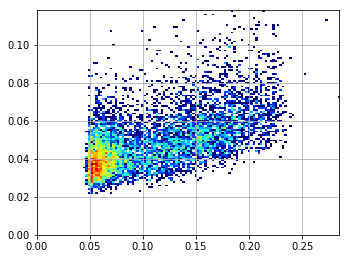

In [11]:
norm = mpl.colors.LogNorm()
my_cm = cm.jet
fig = plt.figure(figsize=(6,4))
H, xedges, yedges = np.histogram2d(
    obs_min['warm_frac'],
    obs_min['dr_rms'],
    bins=125, range=[[0, np.max(obs_min['warm_frac'])],
                     [0, np.percentile(obs_min['dr_rms'], 99.9)]])
ax1 = fig.add_axes([0.14, 0.14, 0.70, 0.78])
ax1.pcolorfast(xedges, yedges, H.T, cmap=my_cm, norm=norm)
plt.grid()

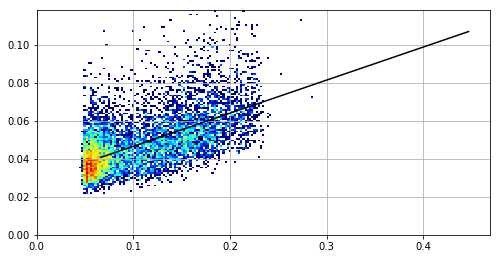

In [12]:

fig = plt.figure(figsize=(9,4))
H, xedges, yedges = np.histogram2d(
    obs_min['warm_frac'],
    obs_min['dr_rms'],
    bins=125, range=[[0, np.max(obs_min['warm_frac'])],
                     [0.0, np.percentile(obs_min['dr_rms'], 99.9)]])
ax1 = fig.add_axes([0.14, 0.14, 0.70, 0.78])
ax1.pcolorfast(xedges, yedges, H.T, cmap=my_cm, norm=norm)

# limit to just interesting fracs and fit the mean                                              
min_frac = get_warm_fracs(limit, '2010:001', -19)
ok = obs_min['warm_frac'] > min_frac
p = np.polyfit(obs_min['warm_frac'][ok], obs_min['dr_rms'][ok], 1)
w = get_warm_fracs(limit, '2022:001', -5)
x = np.arange(min_frac, w + (.05 * w), 0.01)
plt.plot(x, np.polyval(p, x), 'k', label='mean')
plt.grid(True)

by eye fits


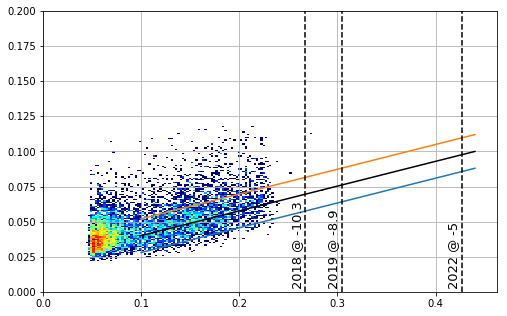

In [13]:
fig = plt.figure(figsize=(9,5))
H, xedges, yedges = np.histogram2d(
    obs_min['warm_frac'],
    obs_min['dr_rms'],
    bins=125, range=[[0, np.max(obs_min['warm_frac'])],
                     [0.0, np.percentile(obs_min['dr_rms'], 99.9)]])
ax1 = fig.add_axes([0.14, 0.14, 0.70, 0.78])
ax1.pcolorfast(xedges, yedges, H.T, cmap=my_cm, norm=norm)

# by eye 
if limit == 100:
    plt.plot([0.10, 0.44], [0.040, 0.1], 'k')
    plt.plot([0.10, 0.44], [0.028, 0.088])
    plt.plot([0.10, 0.44], [0.052, 0.112])
elif limit == 150:
    plt.plot([0.04, 0.35], [0.04, 0.12], 'k')
    plt.plot([0.04, 0.35], [0.03, 0.11])
    plt.plot([0.04, 0.35], [0.05, 0.13])
elif limit == 200:
    plt.plot([0.02, 0.28], [0.037, 0.14], 'k')
    plt.plot([0.02, 0.28], [0.027, 0.125])
    plt.plot([0.02, 0.28], [0.052, 0.155])
cycle19_x = get_warm_fracs(limit, '2018:001', -10.2)
cycle20_x = get_warm_fracs(limit, '2019:001', -8.9)
plt.plot([cycle19_x, cycle19_x], [0, 0.2], 'k', linestyle='--')
plt.text(cycle19_x - .0145, 0.002, "2018 @ -10.3", rotation=90, fontsize=13, verticalalignment='bottom')
plt.plot([cycle20_x, cycle20_x], [0, 0.2], 'k', linestyle='--')
plt.text(cycle20_x - .0145, 0.002, "2019 @ -8.9", rotation=90, fontsize=13, verticalalignment='bottom' )
plt.plot([w, w], [0, 0.2], 'k', linestyle='--')
plt.text(w - .0145, 0.002, "2022 @ -5", rotation=90, fontsize=13, verticalalignment='bottom')
plt.grid()
plt.ylim(0, 0.2);
print("by eye fits")

2022:001 @-5C warm frac is 0.4265190723112064
Datasets              = 0, 1, 2
Method                = neldermead
Statistic             = chi2
Initial fit statistic = 2.04522e+06
Final fit statistic   = 18.1358 at function evaluation 825
Data points           = 57
Degrees of freedom    = 53
Probability [Q-value] = 0.999998
Reduced statistic     = 0.342185
Change in statistic   = 2.0452e+06
   poly0.c0       0.0164107   
   poly0.c1       0.176998    
   poly1.c0       0.0275114   
   poly2.c0       0.0461026   
shared slope fits of binned percentiles


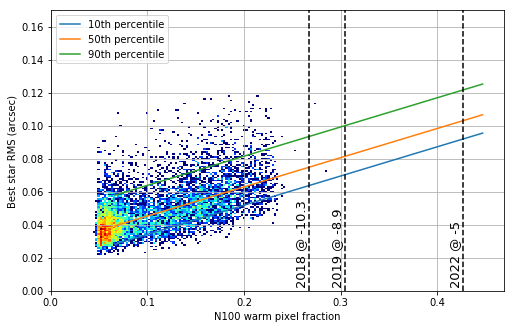

In [14]:
fig = plt.figure(figsize=(9,5))
H, xedges, yedges = np.histogram2d(
    obs_min['warm_frac'],
    obs_min['dr_rms'],
    bins=125, range=[[0, np.max(obs_min['warm_frac'])],
                     [0.0, np.percentile(obs_min['dr_rms'], 99.9)]])
ax1 = fig.add_axes([0.14, 0.14, 0.70, 0.78])
ax1.pcolorfast(xedges, yedges, H.T, cmap=my_cm, norm=norm)
w = get_warm_fracs(limit, '2022:001', -5)
print("2022:001 @-5C warm frac is {}".format(w))


percentiles = [10, 50, 90]
for data_id, percentile in enumerate(percentiles):
    percs = []
    bins = []
    binwidth = 0.01
    for fbin in np.arange(0, 0.25, binwidth):
        ok = (obs_min['warm_frac'] >= fbin) & (obs_min['warm_frac'] < (fbin + binwidth))
        cnts = obs_min[ok]
        if len(cnts) < 100:
            continue
        bins.append(fbin)
        percs.append(np.percentile(obs_min['dr_rms'][ok], percentile))
    ui.load_arrays(data_id, np.array(bins), np.array(percs), np.zeros(len(bins))+.005)
    ui.set_model(data_id, 'polynom1d.poly{}'.format(data_id))
ui.set_method('simplex')
ui.thaw(poly0.c1)
ui.link(poly1.c1, poly0.c1)
ui.link(poly2.c1, poly0.c1)
ui.fit()
plt.plot(x, np.polyval([poly0.c1.val, poly0.c0.val], x), label='10th percentile')
plt.plot(x, np.polyval([poly1.c1.val, poly1.c0.val], x), label='50th percentile')
plt.plot(x, np.polyval([poly2.c1.val, poly2.c0.val], x), label='90th percentile')
#f = ui.get_fit_plot(data_id)    
cycle19_x = get_warm_fracs(limit, '2018:001', -10.2)
cycle20_x = get_warm_fracs(limit, '2019:001', -8.9)
plt.plot([cycle19_x, cycle19_x], [0, 0.2], 'k', linestyle='--')
plt.text(cycle19_x - .0145, 0.002, "2018 @ -10.3", rotation=90, fontsize=13, verticalalignment='bottom')
plt.plot([cycle20_x, cycle20_x], [0, 0.2], 'k', linestyle='--')
plt.text(cycle20_x - .0145, 0.002, "2019 @ -8.9", rotation=90, fontsize=13, verticalalignment='bottom' )
plt.plot([w, w], [0, 0.2], 'k', linestyle='--')
plt.text(w - .0145, 0.002, "2022 @ -5", rotation=90, fontsize=13, verticalalignment='bottom')
plt.ylim(0, .17)
plt.legend(loc='upper left')
plt.xlabel("N{} warm pixel fraction".format(limit))
plt.ylabel("Best star RMS (arcsec)")
plt.grid()
print("shared slope fits of binned percentiles")